# Python API

In this tutorial we will detail the usage of the Python API with real-world data, showing how to integrate tspex with popular packages such as `pandas` and `seaborn`.

## Introduction

In this tutorial we are going to use data from the [Genotype-Tissue Expression (GTEx) project](https://gtexportal.org/), which provides a large catalogue of gene expression across 54 human tissues. In order to speed up the calculations and make the figures clearer, we are going to use only five tissues: Bladder, Liver, Lung, Pancreas and Stomach.

In [1]:
import tspex
import pandas as pd
import seaborn as sns

In [2]:
gtex_link = 'https://storage.googleapis.com/gtex_analysis_v7/rna_seq_data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct.gz'
expression_data = pd.read_csv(gtex_link, sep='\t', index_col='gene_id', skiprows=2)
expression_data = expression_data.loc[:, ['Bladder', 'Liver', 'Lung', 'Pancreas', 'Stomach']]

We'll remove genes that are not expressed in any of the five tissues.

In [3]:
expression_data = expression_data.loc[(expression_data > 0).any(axis=1)]

In [4]:
expression_data.shape

(31872, 5)

In [5]:
expression_data.head()

,Bladder,Liver,Lung,Pancreas,Stomach
gene_id,,,,,
ENSG00000223972.4,0.05878,0.06259,0.06655,0.027255,0.063895
ENSG00000227232.4,14.24000,5.40600,13.68000,5.553000,9.342500
ENSG00000243485.2,0.06097,0.08316,0.06216,0.034055,0.078575
ENSG00000237613.2,0.04113,0.03354,0.03790,0.022915,0.043800
ENSG00000268020.2,0.00000,0.02959,0.00000,0.000000,0.000000


## The `TissueSpecificity` class

The usage of the tspex module is centered on the creation and analysis of `TissueSpecificity` objects. In order to create these objects, two parameters are required: (1) a `pandas` DataFrame containing gene expression data and (2) a tissue-specificity metric.

In [6]:
print(tspex.TissueSpecificity.__doc__)


    Create an object of the TissueSpecificity class.

    Parameters
    ----------
    expression_data : pandas.core.frame.DataFrame
        Pandas DataFrame containing the expression matrix, with rows
        corresponding to genes and columns to tissues/conditions.
    method : str
        A string representing which tissue-expression metric should be
        calculated. One of: 'counts', 'tau', 'gini', 'simpson',
        'shannon_specificity', 'roku_specificity', 'tsi', 'zscore', 'spm',
        'spm_dpm', 'js_specificity', 'js_specificity_dpm'.
    log : bool, default False
        Log-transform the expression matrix before computing tissue-specificity
        by taking the base-2 logarithm of one plus the expression values. By
        default, no transformation is performed.
    transform : bool, default True
        Transform the tissue-specificity values so that they range from 0
        (perfectly ubiquitous) to 1 (perfectly tissue-specific). By default, the
        value is t

The nonobligatory parameters (`log`, `transform` and `threshold`) and the object attributes (`expression_data` and `tissue_specificity`) will be explained throughout the tutorial.

## Tissue-specificity metrics

tspex provides twelve different tissue-specificity metrics that can be divided into two groups:
 - **General scoring metrics:** Describe in a single value how tissue-specific or ubiquitous is a gene across all tissues (`counts`, `tau`, `gini`, `simpson`, `shannon_specificity`, `roku_specificity`, `spm_dpm` and `js_specificity_dpm`).
 - **Individualized scoring metrics:** Quantify how specific is the expression of each gene to each tissue (`tsi`, `zscore`, `spm` and `js_specificity`).

## Example 1: General scoring metric

In this example we are going to quantify the tissue-specificity of each gene using the Tau metric, which is a general scoring metric. Therefore, we will get a single tissue-specificity score per gene.

When creating a `TissueSpecificity` object, you can choose to log-transform the expression values before quantifying tissue-specificity.

In [7]:
tso = tspex.TissueSpecificity(expression_data, 'tau', log=True)

The log-transformed expression matrix is stored in the `expression_data` attribute, which is a regular `pandas` DataFrame.

In [8]:
tso.expression_data.head()

,Bladder,Liver,Lung,Pancreas,Stomach
gene_id,,,,,
ENSG00000223972.4,0.057117,0.060709,0.064429,0.026890,0.061937
ENSG00000227232.4,2.723924,1.857235,2.686486,1.879923,2.336262
ENSG00000243485.2,0.059184,0.079883,0.060305,0.033488,0.075641
ENSG00000237613.2,0.040307,0.032990,0.037199,0.022656,0.042868
ENSG00000268020.2,0.000000,0.029161,0.000000,0.000000,0.000000


The computed tissue-specificity values are stored in the `tissue_specificity` attribute that, in this case, is an one-dimensional `pandas` Series.

In [9]:
tso.tissue_specificity.head()

gene_id
ENSG00000223972.4    0.1981
ENSG00000227232.4    0.1960
ENSG00000243485.2    0.2845
ENSG00000237613.2    0.2235
ENSG00000268020.2    1.0000
dtype: float64

Any of the Series' methods can be used to inspect `tissue_specificity`.

In [10]:
tso.tissue_specificity.quantile([0.5, 0.75, 0.95])

0.50    0.502950
0.75    0.761925
0.95    1.000000
dtype: float64

Two visualization methods are available in tspex: `plot_histogram` and `plot_heatmap`.

`plot_histogram` can be used to verify the distribution of the tissue-specificity values.

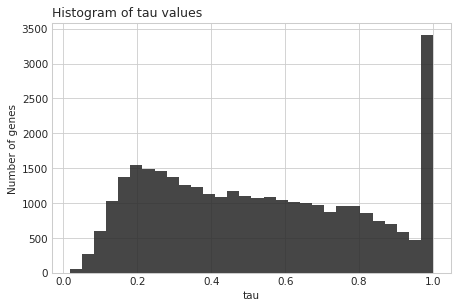

In [11]:
tso.plot_histogram()

Whereas `plot_heatmap` may be used to visualize the amount of genes that are specific for each tissue.

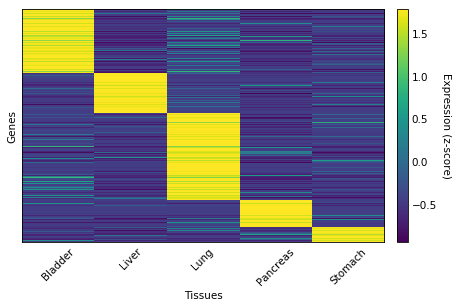

In [12]:
tso.plot_heatmap(threshold=0.8, sort_genes=True, use_zscore=True, gene_names=False)

## Example 2: Individualized scoring metric

In some cases we may be interested in discovering genes that are specifically expressed in one or more tissues of interest. In this situation, general scoring metrics are not be the best choice, as they would only tell us how tissue-specific is each gene, regardless of the tissue.

Accordingly, in this example we are going to quantify the tissue-specificity of each gene using the SPM metric, an individualized scoring metric.

In [13]:
tso = tspex.TissueSpecificity(expression_data, 'spm', log=True)

As the SPM metric computes how specific each gene is in each tissue, the `tissue_specificity` attribute is a two-dimensional `pandas` DataFrame.

In [14]:
tso.tissue_specificity.head()

,Bladder,Liver,Lung,Pancreas,Stomach
gene_id,,,,,
ENSG00000223972.4,0.4565,0.4852,0.5149,0.2149,0.4950
ENSG00000227232.4,0.5235,0.3569,0.5163,0.3613,0.4490
ENSG00000243485.2,0.4147,0.5598,0.4226,0.2347,0.5301
ENSG00000237613.2,0.5020,0.4108,0.4633,0.2822,0.5339
ENSG00000268020.2,0.0000,1.0000,0.0000,0.0000,0.0000


To inspect the distribution of the tissue-specificity values separately for each tissue, we can use the `violinplot` function from the `seaborn` package.

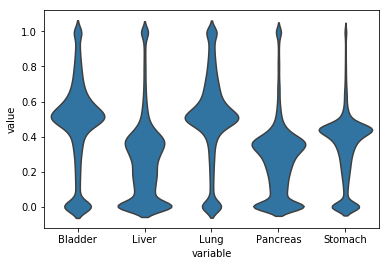

In [15]:
sns.violinplot(x="variable", y="value", inner=None, scale="count", color='C0',
               data=tso.tissue_specificity.melt());

The `query` method can be used to select genes that satisfy certain criteria. In this case, we are selecting genes that are preferentially expressed in the bladder and lung.

In [16]:
selected_genes_specificity = tso.tissue_specificity.query('Bladder >= 0.6 & Lung >= 0.6')
selected_genes_specificity.shape

(1282, 5)

In [17]:
selected_genes_expression = tso.expression_data.reindex(selected_genes_specificity.index)
selected_genes_specificity.head()

,Bladder,Liver,Lung,Pancreas,Stomach
gene_id,,,,,
ENSG00000228526.2,0.6410,0.1192,0.6566,0.2270,0.3038
ENSG00000233623.2,0.6775,0.1907,0.6832,0.1948,0.0000
ENSG00000171819.4,0.7653,0.0433,0.6072,0.0858,0.1908
ENSG00000202461.1,0.6564,0.0000,0.6383,0.2459,0.3181
ENSG00000162493.12,0.6019,0.0214,0.6080,0.2072,0.4740


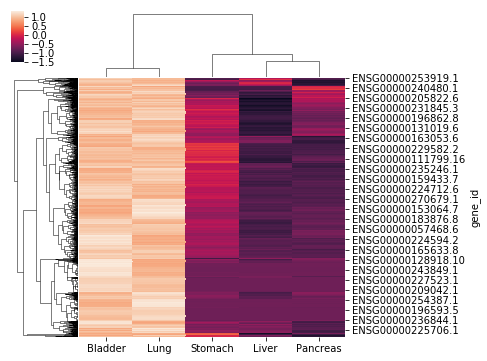

In [18]:
sns.clustermap(selected_genes_expression, figsize=(6,6), z_score=0);

## Example 3: The `transform` parameter

When a `TissueSpecificity` object is created, the computed tissue-specificity values are transformed so that they fall within 0 (perfectly ubiquitous expression) and 1 (perfectly tissue-specific expression). If the user wants to obtain the untransformed values given by the chosen tissue-specificity metric, he can set the `transform` argument to `False`. The following metrics are affected by changes in this parameter: `gini`, `simpson`, `shannon_specificity`, `roku_specificity` and `zscore`.

For instance, untransformed values obtained with the `roku_specificity` method fall within 0 and log2(number of tissues).

In [19]:
tso = tspex.TissueSpecificity(expression_data, 'roku_specificity', log=True)
tso.tissue_specificity.max()

1.0

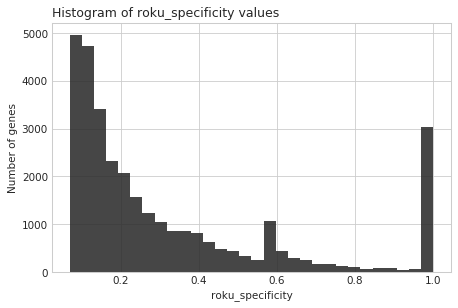

In [20]:
tso.plot_histogram()

In [21]:
tso = tspex.TissueSpecificity(expression_data, 'roku_specificity', log=True, transform=False)
tso.tissue_specificity.max()

2.3219

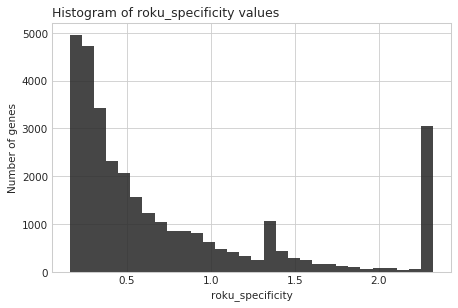

In [22]:
tso.plot_histogram()

## Example 4: The `threshold` parameter of the `counts` metric

The `counts` metric quantifies tissue-specificity as the proportion of tissues above a given expression threshold. Consequently, the `threshold` parameter directly influences the results obtained when using this method.

In this example we will first set `threshold` to 5. Therefore, genes will be considered expressed in any given tissue if their expression is above this value.

In [23]:
tso = tspex.TissueSpecificity(expression_data, 'counts', threshold=5)
sum(tso.tissue_specificity >= 0.8)

2400

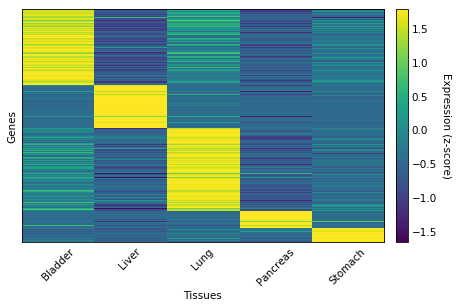

In [24]:
tso.plot_heatmap(0.8, sort_genes=True, use_zscore=True, gene_names=False)

If we increase `threshold` to 50 fewer genes will be selected.

In [25]:
tso = tspex.TissueSpecificity(expression_data, 'counts', threshold=50)
sum(tso.tissue_specificity >= 0.8)

1557

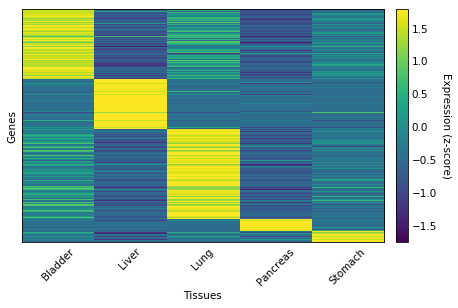

In [26]:
tso.plot_heatmap(0.8, sort_genes=True, use_zscore=True, gene_names=False)